# 2D Registration Script Support from Teodora Szasz:
- Computational Scientist at Research Computing Center

### Goals of this script enabling the registration of prostate images across various imaging techniques

- Histology will be the fixed image while the T2W MRI Images will be the "moving" images


- Step 1: Work first on loading the data per imaging format and performing image transformations to rotate, translate, and etc. for each of the imaging formats.


- Step 2: Rigid Registration: merely rotating the image, which T2W slice is the most closely aligned with the histology slice and to what degree (DICE similarity coefficient, MSE, etc)


- Step 3: Non-Rigid Registration: once we have succeeded with the Rigid Registration, we shall move to more advanced methods.


- Step 4: Once we have succeeded in the previous steps, we shall move to 3D registration approaches across the histology slices & MRI Images (T2W, and etc.)


## Import Libraries & Utilities (functions) that will be required for the subsequent python script

In [1]:
import SimpleITK as sitk
%matplotlib notebook
import gui
import registration_gui as rgui
import registration_utilities as ru
import registration_callbacks as rc
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib notebook

from ipywidgets import interact, fixed
from IPython.display import clear_output

In [2]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
import os
OUTPUT_DIR = 'Output'

# Utility functions

A number of utility callback functions for image display and for plotting the similarity metric during registration.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

## Read images

- We first read the images, casting the pixel type to that required for registration (Float32 or Float64) and look at them.

In [5]:
input_dicom_image = 'T2W'
input_dir_histo = 'histo'

In [6]:
movingImg = sitk.ReadImage('T2W/108_Base.tif', sitk.sitkFloat32)

# Moving Image (T2W (DICOM)) Descriptive Statistics

In [7]:
selected_image = movingImg
print('Before modification:')
print('origin: ' + str(selected_image.GetOrigin()))
print('size: ' + str(selected_image.GetSize()))
print('spacing: ' + str(selected_image.GetSpacing()))
print('direction: ' + str(selected_image.GetDirection()))
print('pixel type: ' + str(selected_image.GetPixelIDTypeAsString()))
print('number of pixel components: ' + str(selected_image.GetNumberOfComponentsPerPixel()))

# comment out the setting of the origin and spacing to a specific value as I am unaware of the unintended consequences of performing this action
#selected_image.SetOrigin((78.0, 76.0, 77.0))
#selected_image.SetSpacing([0.5,0.5,3.0])

print('\nAfter modification:')
print('origin: ' + str(selected_image.GetOrigin()))
print('spacing: ' + str(selected_image.GetSpacing()))

Before modification:
origin: (0.0, 0.0)
size: (512, 512)
spacing: (1.0, 1.0)
direction: (1.0, 0.0, 0.0, 1.0)
pixel type: 32-bit float
number of pixel components: 1

After modification:
origin: (0.0, 0.0)
spacing: (1.0, 1.0)


In [8]:
# Plotting Image

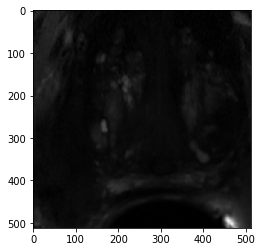

In [9]:
plt.figure(1)
moving2D = sitk.GetArrayViewFromImage(movingImg)
plt.imshow(moving2D, cmap='gray')

### Making a black volume
- with the parameters primarily based on the histology image parameters (0.3125, 0.3125) spacing in x & y direction
- setting the z parameters as 4 since there are 4 millimeter (3 mm per slice and 1 mm fixation/setting of the slice) in the z direction

In [10]:
#moving2d = sitk.GetImageFromArray(slice_MRI_moving) ##seems to be converting the 2D image array required for matplotlib to be converted to 3D for the sitk package to properly function
moving2d = sitk.GetImageFromArray(moving2D)

In [11]:
# make a black volume
vol_mri = sitk.Image((moving2d.GetWidth(),moving2d.GetHeight(),1),moving2d.GetPixelID(), moving2d.GetNumberOfComponentsPerPixel())
vol_mri.SetSpacing([0.3125, 0.3125, 4.0])

### Pasting/superimposing the histology slice over the black volume with the same parameters as the black volume

In [12]:
pasted_vol_mri = sitk.Image((moving2d.GetWidth(),moving2d.GetHeight(),1),moving2d.GetPixelID(), moving2d.GetNumberOfComponentsPerPixel())
pasted_vol_mri.SetSpacing([0.3125, 0.3125, 4.0])

### Joining the black volume and histology slice together via the Join Series, Paste and Add functions within Simple ITK

In [13]:
slice_vol_mri = sitk.JoinSeries(moving2d)
moving3D_prep = sitk.Paste(vol_mri, slice_vol_mri, slice_vol_mri.GetSize(), destinationIndex=[0,0,0])
#moving3D = sitk.Add(pasted_vol_mri, moving3D_prep)


In [14]:
# print(moving3D_prep)

In [15]:
moving3D = sitk.Add(pasted_vol_mri, moving3D_prep)

In [16]:
moving3D.SetOrigin((0.0, 0.0, 0.0))###setting the origin of the T2W image at 0,0,0

In [17]:
moving3D.GetOrigin()### ensuring the origin is set at (0,0,0) for the moving 3D T2W object

(0.0, 0.0, 0.0)

## Fixed Image (Histology(.tif))  Descriptive Statistics

To better understand the image characteristics that we will be looking to manipulate/register with other images later on

In [18]:
fixedImg = sitk.ReadImage('histo/Patient108_Base_Resized.tif', sitk.sitkFloat32)

In [19]:
selected_image = fixedImg
print('Before modification:')
print('origin: ' + str(selected_image.GetOrigin()))
print('size: ' + str(selected_image.GetSize()))
print('spacing: ' + str(selected_image.GetSpacing()))
print('direction: ' + str(selected_image.GetDirection()))
print('pixel type: ' + str(selected_image.GetPixelIDTypeAsString()))
print('number of pixel components: ' + str(selected_image.GetNumberOfComponentsPerPixel()))

# comment out the setting of the origin and spacing to a specific value as I am unaware of the unintended consequences of performing this action
#selected_image.SetOrigin((78.0, 76.0, 77.0))

selected_image.SetSpacing([1.0,1.0])

print('\nAfter modification:')
print('size: ' + str(selected_image.GetSize()))
print('origin: ' + str(selected_image.GetOrigin()))
print('spacing: ' + str(selected_image.GetSpacing()))

Before modification:
origin: (0.0, 0.0)
size: (512, 512)
spacing: (0.352733672911958, 0.352733672911958)
direction: (1.0, 0.0, 0.0, 1.0)
pixel type: 32-bit float
number of pixel components: 1

After modification:
size: (512, 512)
origin: (0.0, 0.0)
spacing: (1.0, 1.0)


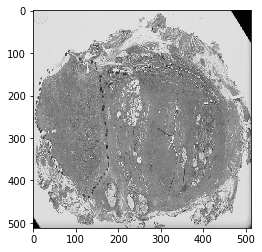

In [20]:
plt.figure(1)
fixed2D = sitk.GetArrayViewFromImage(fixedImg)
plt.imshow(fixed2D, cmap='gray')

- We create a 3D slice from 2D image (to mach it to the Dicom slice)

In [21]:
#moving2d = sitk.GetImageFromArray(slice_MRI_moving) ##seems to be converting the 2D image array required for matplotlib to be converted to 3D for the sitk package to properly function
fixed2d = sitk.GetImageFromArray(fixed2D)

# Exploration Data Analysis (EDA) and Image Preparation for Registration

### Making a black volume
- with the parameters primarily based on the histology image parameters (0.3125, 0.3125) spacing in x & y direction
- setting the z parameters as 4 since there are 4 millimeter (3 mm per slice and 1 mm fixation/setting of the slice) in the z direction

In [22]:
# make a black volume
vol_histo = sitk.Image((fixed2d.GetWidth(),fixed2d.GetHeight(),1),fixed2d.GetPixelID(), fixed2d.GetNumberOfComponentsPerPixel())
vol_histo.SetSpacing([0.3125, 0.3125, 4.0])

### Pasting/superimposing the histology slice over the black volume with the same parameters as the black volume

In [23]:
pasted_vol_histo = sitk.Image((fixed2d.GetWidth(),fixed2d.GetHeight(),1),fixed2d.GetPixelID(), fixed2d.GetNumberOfComponentsPerPixel())
pasted_vol_histo.SetSpacing([0.3125, 0.3125, 4.0])

### Joining the black volume and histology slice together via the Join Series, Paste and Add functions within Simple ITK

In [24]:
slice_vol = sitk.JoinSeries(fixed2d)
fixed3D_prep = sitk.Paste(vol_histo, slice_vol, slice_vol.GetSize(), destinationIndex=[0,0,0])
fixed3D = sitk.Add(pasted_vol_histo, fixed3D_prep)

In [25]:
moving3D.SetOrigin((0.0, 0.0, 0.0))###setting the origin of the T2W image at 0,0,0

In [26]:
moving3D.GetOrigin()### ensuring the origin is set at (0,0,0) for the moving 3D T2W object

(0.0, 0.0, 0.0)

In [27]:
fixed3D.GetOrigin()### ensure the 3D histology slice has the same origin/reference point as the T2W/moving 3D image

(0.0, 0.0, 0.0)

# Initial Alignment

Use the CenteredTransformInitializer to align the centers of the two volumes and set the center of rotation to the center of the fixed image.

In [28]:
initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed2d,fixed2d.GetPixelID()), 
                                                      moving2d, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

In [29]:
initial_transform3D = sitk.CenteredTransformInitializer(sitk.Cast(fixed3D,fixed3D.GetPixelID()), 
                                                      moving3D, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

#### Image parameter initatialization that will be required for each image to set the appropriate window level argument within the Graphical User Interface utility

In [30]:
#fixed_window_level = [835,162]
#moving_window_level = [1306,220]

In [31]:
%matplotlib notebook
#%matplotlib inline

<IPython.core.display.Javascript object>


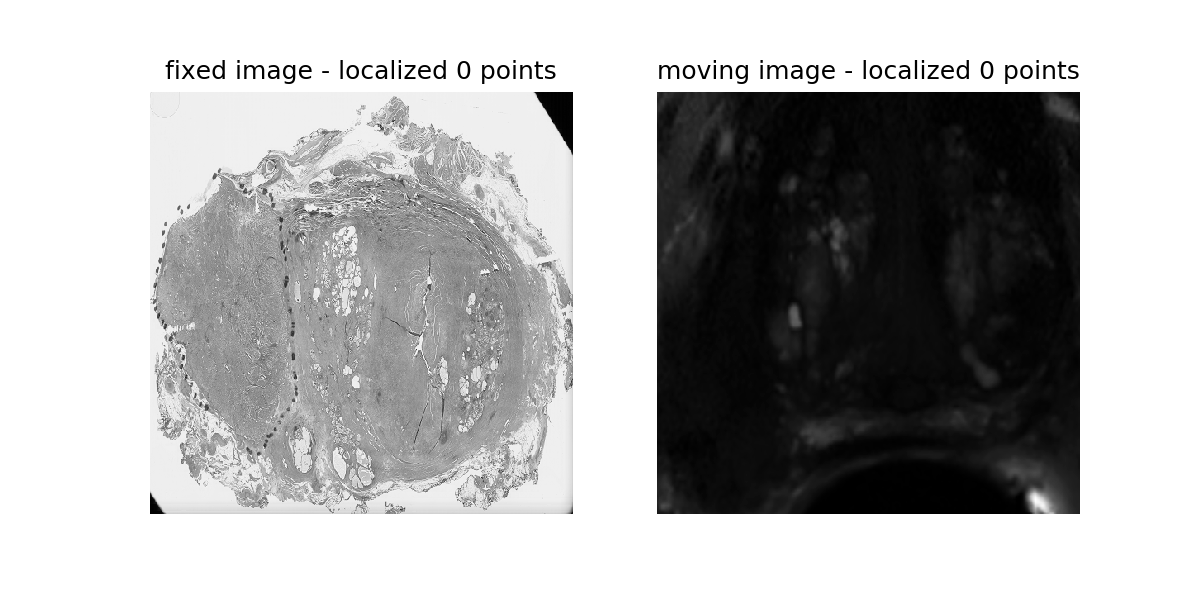

In [32]:
gui.RegistrationPointDataAquisition(fixed3D, moving3D, figure_size=(8,4), known_transformation=initial_transform3D);

In [33]:
moving_resampled = sitk.Resample(fixed3D, moving3D, initial_transform3D, sitk.sitkLinear, 0.0, moving3D.GetPixelID())

In [34]:
%matplotlib inline

In [35]:
interact(display_images_with_alpha, image_z=(0,fixed3D.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed3D), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=0, description='image_z', max=0), FloatSlider(value=0.5, description='al…

In [36]:
%matplotlib notebook
#%matplotlib inline

<IPython.core.display.Javascript object>


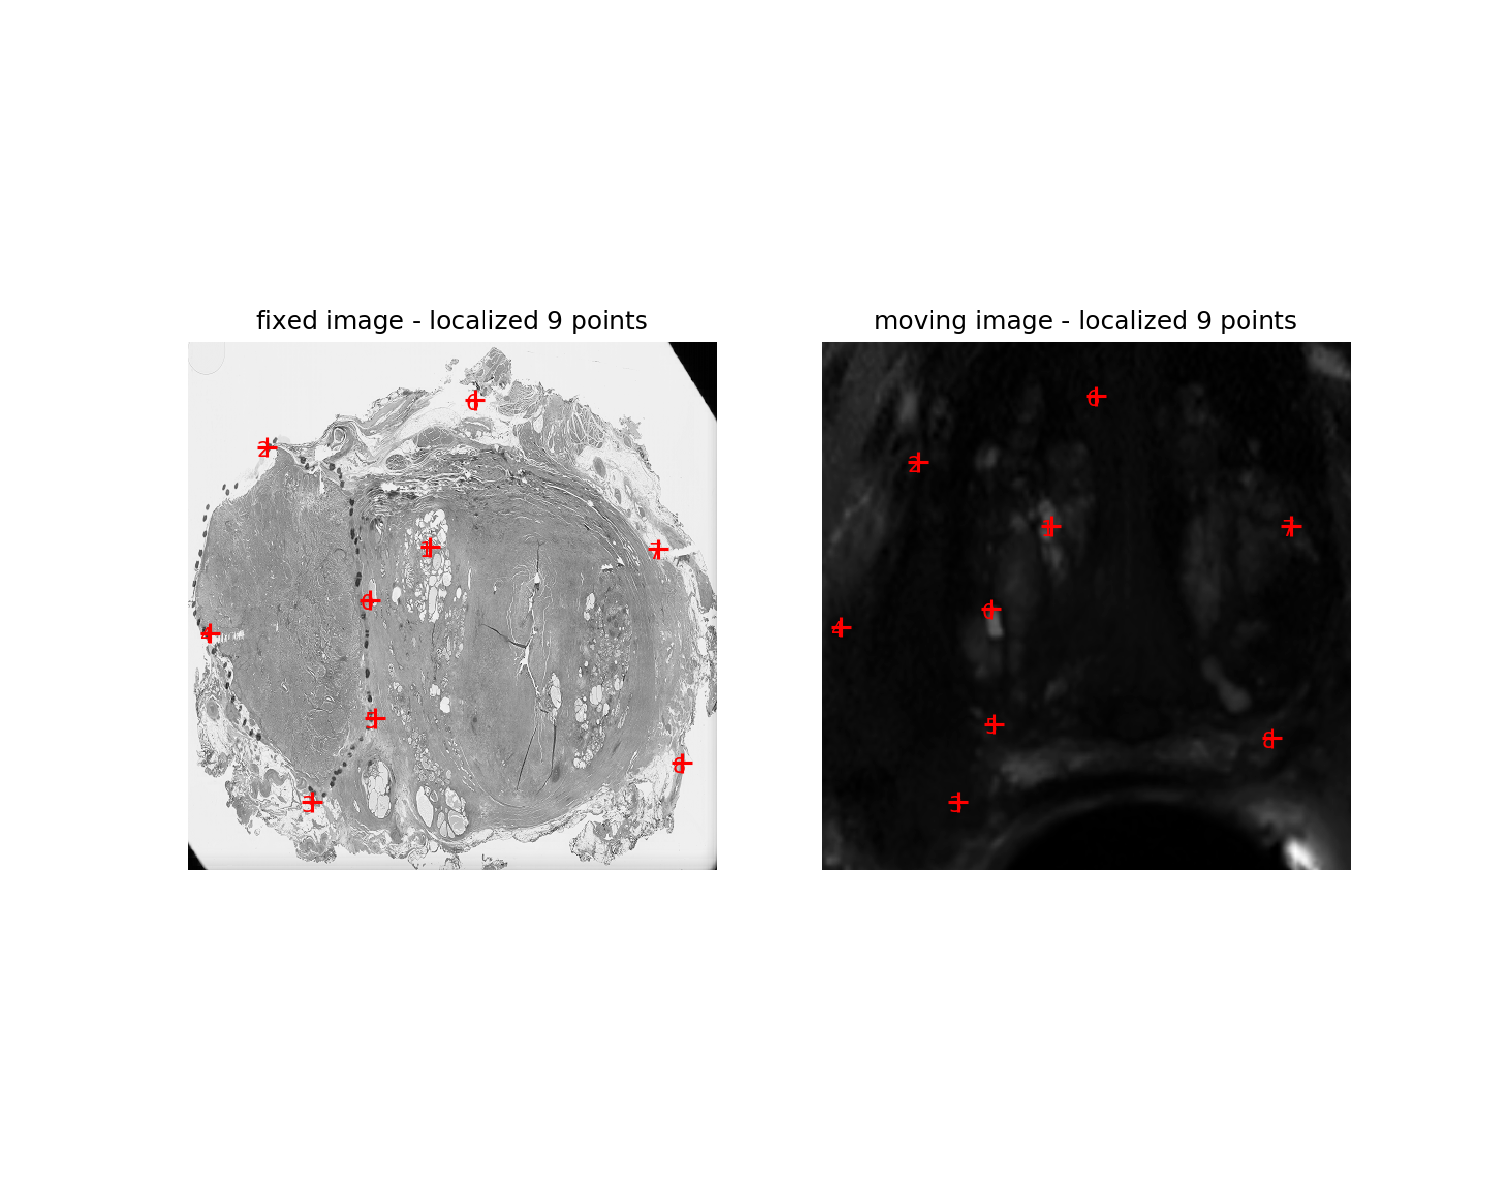

In [38]:
point_acquisition_interface = gui.RegistrationPointDataAquisition(fixed3D, moving3D)

In [55]:
selected_points=point_acquisition_interface.get_points()
fixed_image_points = [item for item in selected_points[0]]
moving_image_points = [item for item in selected_points[1]]

# Setting Image Registration Method and Parameters

In [56]:
%matplotlib inline

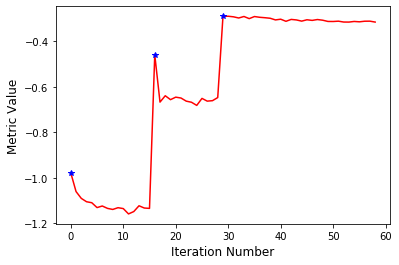

In [57]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
#registration_method.SetMetricAsCorrelation() #MattesMutualInformation numberOfHistogramBins=50
#registration_method.SetMetricAsMeanSquares() #MattesMutualInformation()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=150)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear) # sitkLinear sitkNearestNeighbor

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1]) #4,2,1
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0]) #2,1,0
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))


final_transform = registration_method.Execute(fixed2d, moving2d)

## Registration Metric value

In [58]:
# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.30971552812280645
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 30.


In [59]:
#print(initial_transform)

In [60]:
print(final_transform)

itk::simple::Transform
 CompositeTransform (00000210A46B5110)
   RTTI typeinfo:   class itk::CompositeTransform<double,2>
   Reference Count: 1
   Modified Time: 58862
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler2DTransform (00000210A46B5E00)
     RTTI typeinfo:   class itk::Euler2DTransform<double>
     Reference Count: 1
     Modified Time: 58703
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.999065 -0.0432438 
       0.0432438 0.999065 
     Offset: [-8.30741, -25.0905]
     Center: [255.5, 255.5]
     Translation: [-19.5952, -14.2807]
     Inverse: 
       0.999065 0.0432438 
       -0.0432438 0.999065 
     Singular: 0
     Angle       = 0.0432573
   End of MultiTransform.
<<<<<<<<<<
   TransformsToOptimizeFlags, begin() to end(): 
      1 
   TransformsToOptimize in queue, from begin to end:
   End of TransformsToOptimizeQueue.
<<<<<<<<<<
   End of CompositeTransfor

# Rigid Registration: Registration Tuning

#### Generate a larger point set as a reference

Reference data errors (FRE) in millimeters, mean(std): 5.35(3.57), max: 12.88


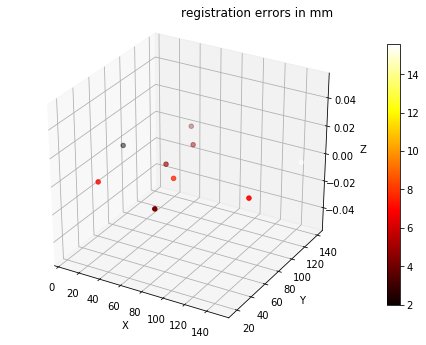

Before registration, errors (TRE) in millimeters, mean(std): 6.25(3.68), max: 15.55


In [61]:
# Estimate the reference_transform defined by the RIRE fiducials and check that the FRE makes sense (low) 
R, t = ru.absolute_orientation_m(fixed_image_points, moving_image_points)
reference_transform = sitk.Euler3DTransform()
reference_transform.SetMatrix(R.flatten())
reference_transform.SetTranslation(t)
reference_errors_mean, reference_errors_std, _, reference_errors_max,_ = ru.registration_errors(reference_transform, fixed_image_points, moving_image_points)
print('Reference data errors (FRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(reference_errors_mean, reference_errors_std, reference_errors_max))

# Generate a reference dataset from the reference transformation 
# (corresponding points in the fixed and moving images).
fixed_points = ru.generate_random_pointset(image=moving3D, num_points=300)
moving_points = [reference_transform.TransformPoint(p) for p in fixed_points]    

# Compute the TRE prior to registration.
pre_errors_mean, pre_errors_std, pre_errors_min, pre_errors_max, _ = ru.registration_errors(sitk.Euler3DTransform(), fixed_image_points, moving_image_points, display_errors = True)
print('Before registration, errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(pre_errors_mean, pre_errors_std, pre_errors_max))

## Initial Alignment
##### We use the CenteredTransformInitializer. Should we use the GEOMETRY based version or the MOMENTS based one?

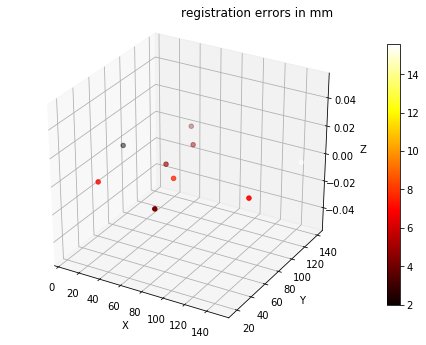

After initialization, errors (TRE) in millimeters, mean(std): 6.25(3.68), max: 15.55


In [62]:
initial_transform3D = sitk.CenteredTransformInitializer(fixed3D, 
                                                      moving3D, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

initial_errors_mean, initial_errors_std, initial_errors_min, initial_errors_max, _ = ru.registration_errors(initial_transform3D, fixed_image_points, moving_image_points, min_err=pre_errors_min, max_err=pre_errors_max, display_errors=True)
print('After initialization, errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(initial_errors_mean, initial_errors_std, initial_errors_max))

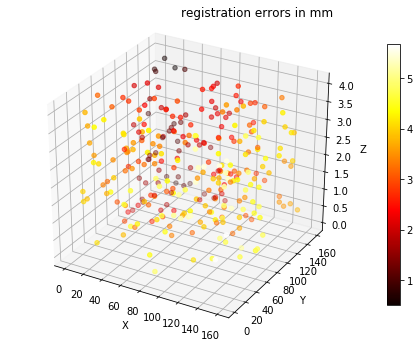

After initialization, errors (TRE) in millimeters, mean(std): 3.29(1.17), max: 5.68


In [63]:
final_errors_mean, final_errors_std, _, final_errors_max,_ = ru.registration_errors(initial_transform3D, fixed_points, moving_points, display_errors=True)
print('After initialization, errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(final_errors_mean, final_errors_std, final_errors_max))

# Visualy evaluate the results :

### Image Resampling usinf Final Transformation Parameters and Interpolators

In [64]:
#print(final_transform)

In [65]:
fixed2d_resampled = sitk.Resample(fixedImg, final_transform, sitk.sitkLinear)

In [66]:
fixed2d_resampled

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x00000210A241F900> >

In [67]:
#print(moving2d_resampled)

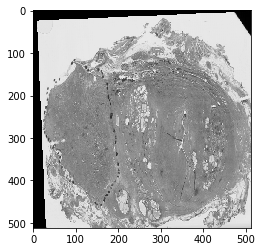

In [68]:
plt.figure(1)
fixed2d = sitk.GetArrayViewFromImage(fixed2d_resampled)
plt.imshow(fixed2d, cmap='gray')

### Create a 3D slice from 2D image

In [69]:
#moving2d = sitk.GetImageFromArray(slice_MRI_moving) ##seems to be converting the 2D image array required for matplotlib to be converted to 3D for the sitk package to properly function
fixed2d = sitk.GetImageFromArray(fixed2d)

### Making a black volume
- with the parameters primarily based on the histology image parameters (0.3125, 0.3125) spacing in x & y direction
- setting the z parameters as 4 since there are 4 millimeter (3 mm per slice and 1 mm fixation/setting of the slice) in the z direction

In [70]:
# make a black volume
vol_histo = sitk.Image((fixed2d.GetWidth(),fixed2d.GetHeight(),1),fixed2d.GetPixelID(), fixed2d.GetNumberOfComponentsPerPixel())
vol_histo.SetSpacing([0.3125, 0.3125, 4.0])

### Pasting/superimposing the histology slice over the black volume with the same parameters as the black volume

In [71]:
pasted_vol_histo = sitk.Image((fixed2d.GetWidth(),fixed2d.GetHeight(),1),fixed2d.GetPixelID(), fixed2d.GetNumberOfComponentsPerPixel())
pasted_vol_histo.SetSpacing([0.3125, 0.3125, 4.0])

### Joining the black volume and histology slice together via the Join Series, Paste and Add functions within Simple ITK

In [72]:
slice_vol = sitk.JoinSeries(fixed2d)
fixed3D_prep = sitk.Paste(vol_histo, slice_vol, slice_vol.GetSize(), destinationIndex=[0,0,0])
fixed3D = sitk.Add(pasted_vol_histo, fixed3D_prep)

In [73]:
%matplotlib inline

In [74]:
moving_resampled = sitk.Resample(fixed3D, moving3D, initial_transform3D, sitk.sitkLinear, 0.0, moving3D.GetPixelID())
fixed_intensity_range = (0,150)
moving_intensity_range = (-500,65535)

interact(ru.display_images_with_alpha, image_z=(0,moving3D.GetSize()[2]), alpha=(0.0,1.0,0.05), 
         image1 = fixed(sitk.IntensityWindowing(moving3D, fixed_intensity_range[0], fixed_intensity_range[1])), 
         image2=fixed(sitk.IntensityWindowing(fixed3D, moving_intensity_range[0], moving_intensity_range[1])));

interactive(children=(IntSlider(value=0, description='image_z', max=1), FloatSlider(value=0.5, description='al…

# Dice Similiarity

In [ ]:
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as pimg

In [ ]:
img = sitk.ReadImage('T2W/108_Base.tif', sitk.sitkFloat32)
#img = Image.open('T2W/101_Apex.tif')

In [ ]:
# Making Grayscale and save
from PIL import Image, ImageOps

In [ ]:
#img2 = sitk.ReadImage('histo/Transformed_Image.tif', sitk.sitkFloat32)
#img2 = Image.open('histo/Transformed_Image.tif')
#newsize = (512, 512) 
#img2 = img2.resize(newsize)
img2 = fixed2d_resampled

In [ ]:
def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        else:
            intersection = np.logical_and(img, img2)
            value = (2. * intersection.sum())  / (img.sum() + img2.sum())
        return value 



In [ ]:
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as pimg

In [ ]:
#print(img)
img = np.asarray(img).astype(np.bool)
print(img)
print(img.shape)
print('_'*40)

#print(img2)
img2 = np.asarray(img2).astype(np.bool)
print(img2)
print(img2.shape)
print('%'*40)


In [ ]:
value = dice_coef(img, img2)
print(value) 